In [1]:
#Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, train_test_split
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from numpy.random import RandomState
from catboost import CatBoostClassifier,cv, Pool
import warnings
%matplotlib inline

In [3]:
#Cчитаем данные
X = pd.read_csv('data/orange_small_churn_data.train')
y = pd.read_csv('data/orange_small_churn_labels.train', header=None)

In [54]:
print('total number of features', X.shape[1])

total number of features 230


In [55]:
X.head(3)

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,oslk,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,zCkv,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN


In [56]:
#проверим данные на пропуски по строкам
X.isnull().sum(axis=1)

0        169
1        156
2        160
3        164
4        161
        ... 
39995    154
39996    162
39997    159
39998    160
39999    161
Length: 40000, dtype: int64

In [57]:
#проверим данные на пропуски по стоблцам
X.isnull().sum(axis=0).head(15)

Var1     39430
Var2     38994
Var3     38995
Var4     38725
Var5     38835
Var6      4435
Var7      4440
Var8     40000
Var9     39430
Var10    38835
Var11    38995
Var12    39536
Var13     4440
Var14    38995
Var15    40000
dtype: int64

В некоторых признаках отсутствуют все данные, в других очень много пропусков. Для визуализации выкинем признаки, в которых отсутвтуют все значения по столбцу.
Кроме того можно увидеть, что в некоторых признаках отсутствует одинаковое количество данных, возможно в данных есть какой-то порядок.

In [58]:
X = X.dropna(how='all', axis=1)
#выбросим признаки где менее 90% информации по столбцу
X = X.dropna(thresh=X.shape[0] * 0.1, axis=1)

In [59]:
#Достанем числовые и категориальные признаки
num_cols = X.dtypes[X.dtypes != 'object'].index
cat_cols = X.dtypes[X.dtypes == 'object'].index

In [60]:
#Проверим наличие ошибочных дубликатов
X[X.duplicated(keep=False)]

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229


In [61]:
#определим количество уникальных значений в признаках
n_uniq = X.nunique(dropna=False)
#проверим на константные
n_uniq.sort_values(ascending=False)

Var113    38902
Var81     34546
Var133    30307
Var153    29786
Var134    26814
          ...  
Var196        4
Var218        3
Var208        3
Var201        3
Var211        2
Length: 76, dtype: int64

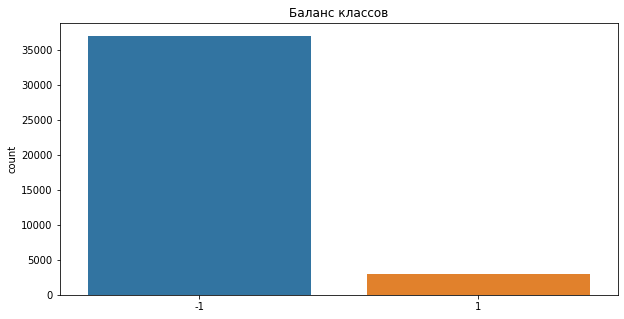

In [11]:
#Баланс классов
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(np.ravel(y))
plt.title('Баланс классов')
plt.show()

Сильный дебаланс классов. Если данные шумные, модель будет испытывать проблемы с порогом точности/полноты. Поскольку пользуемся AUC на нее это не должно повлиять, поскольку AUC нормируется на размер класса. При подборе гиперпараметров надо учесть баланс классов.

### Вещественные признаки

Поскольку признаки имеют разную природу посчитать корреляцию Пирсона/Спирмена по ним не имеет большого смысла, данные критерии не предназначены для такого употребления. Воспользуемся другой стратегией:
* Признаки будут коррелированны положительно, если E(X1|X2=1) > E(X1|X2=-1), отрицательно наоборот;
* За меру корреляции возьмем разность мат.ожиданий E(X1|X2=1) - E(X1|X2=-1)

In [12]:
scaler = StandardScaler()
df = X.copy()
#Будем считать только по известным данным без импутации пропусокв
#Функция вычисляющая мат.ожидания и возвращающая корреляцию между числовой и бинарной переменными
#Данные анонимные, будем считать что среди них нет категориальных
def corr_calc(column):
    #матрица переменная-отклик
    matrix = pd.concat((df[column], pd.Series(np.ravel(y))), axis=1)
    matrix = matrix.dropna()
    #Данные имеют разный масштаб и их нужно сравнивать между собой, произведем нормализацию
    matrix[column] = scaler.fit_transform(matrix[column].values.reshape(-1, 1))

    # Расчет E(X1|X2=1)
    E_X_churn = matrix[matrix[0] == 1][column].mean()
    
    # Расчет E(X1|X2=-1)
    E_X_notchurn = matrix[matrix[0] == -1][column].mean()
    
    #корреляционный коэффициент
    сorr = E_X_churn - E_X_notchurn
    #знак корреляции не важен, найдем только коррелирующие переменные
    return np.abs(E_X_churn - E_X_notchurn)

In [13]:
#Посчитаем корреляции между признаками
#хранить будем в переменной
correlation_list = []

#по всем колонкам с целочисленными значениями вычисляем корреляции и записываем в контейнер
for column in num_cols:
    correlation_list.append([corr_calc(column), column])
    
#pandas объект для хранения корреляций
df_corr = pd.DataFrame(correlation_list, columns=['correlation', 'variable']).sort_values(
    by='correlation',  ascending=False)  
df_corr.head(10)

,correlation,variable
41,0.463551,Var189
1,0.271402,Var7
14,0.265033,Var73
28,0.231393,Var126
24,0.213831,Var113
34,0.199773,Var144
2,0.181259,Var13
12,0.161629,Var65
13,0.159126,Var72
18,0.133861,Var81


Некоторые переменные имеют хорошую корреляцию с откликом, визуализируем топ20 наиболее коррелированных

In [22]:
#20 переменных с наибольшей корреляцией
top20_index = df_corr['variable']
#соберем матрицу. удалим все пропуски и построим попарные pairplot
matrix_corr = pd.concat((X[top20_index], pd.Series(np.ravel(y)).replace({1:'churn', -1:'not_churn'})), axis=1)
matrix_corr.rename(columns={0:'target'}, inplace=True)

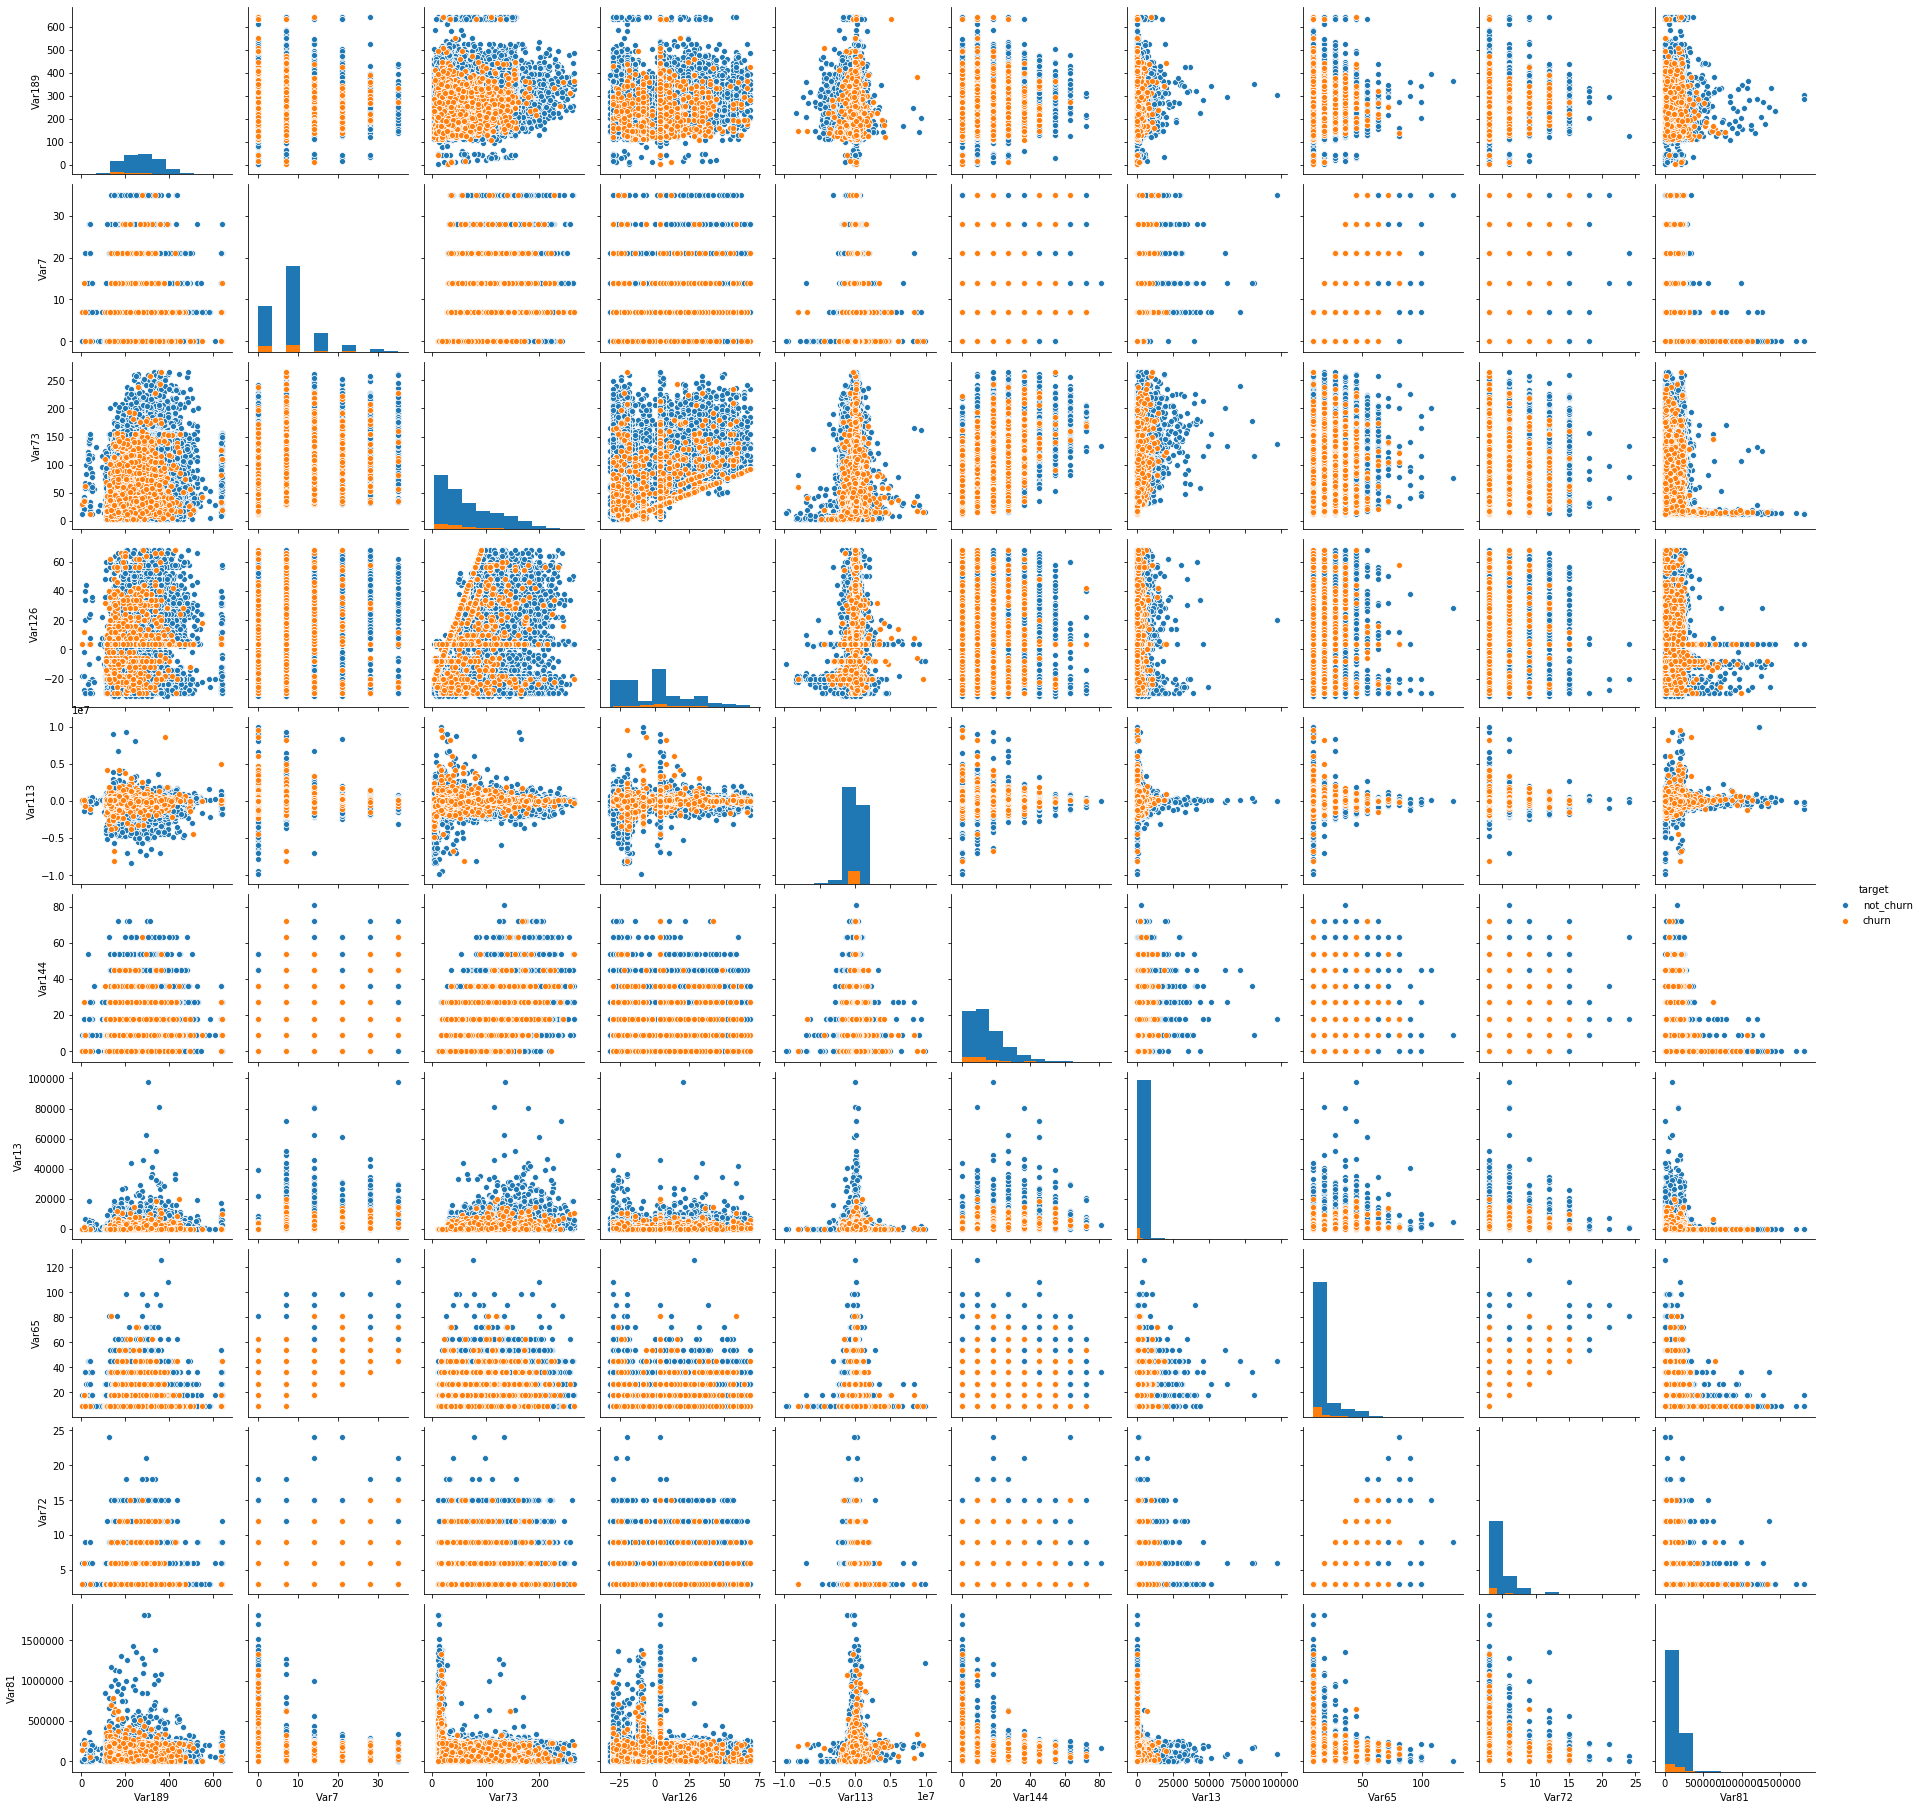

In [23]:
sns.pairplot(hue='target', data=matrix_corr.iloc[:, list(range(10)) + [-1]], diag_kind='hist')

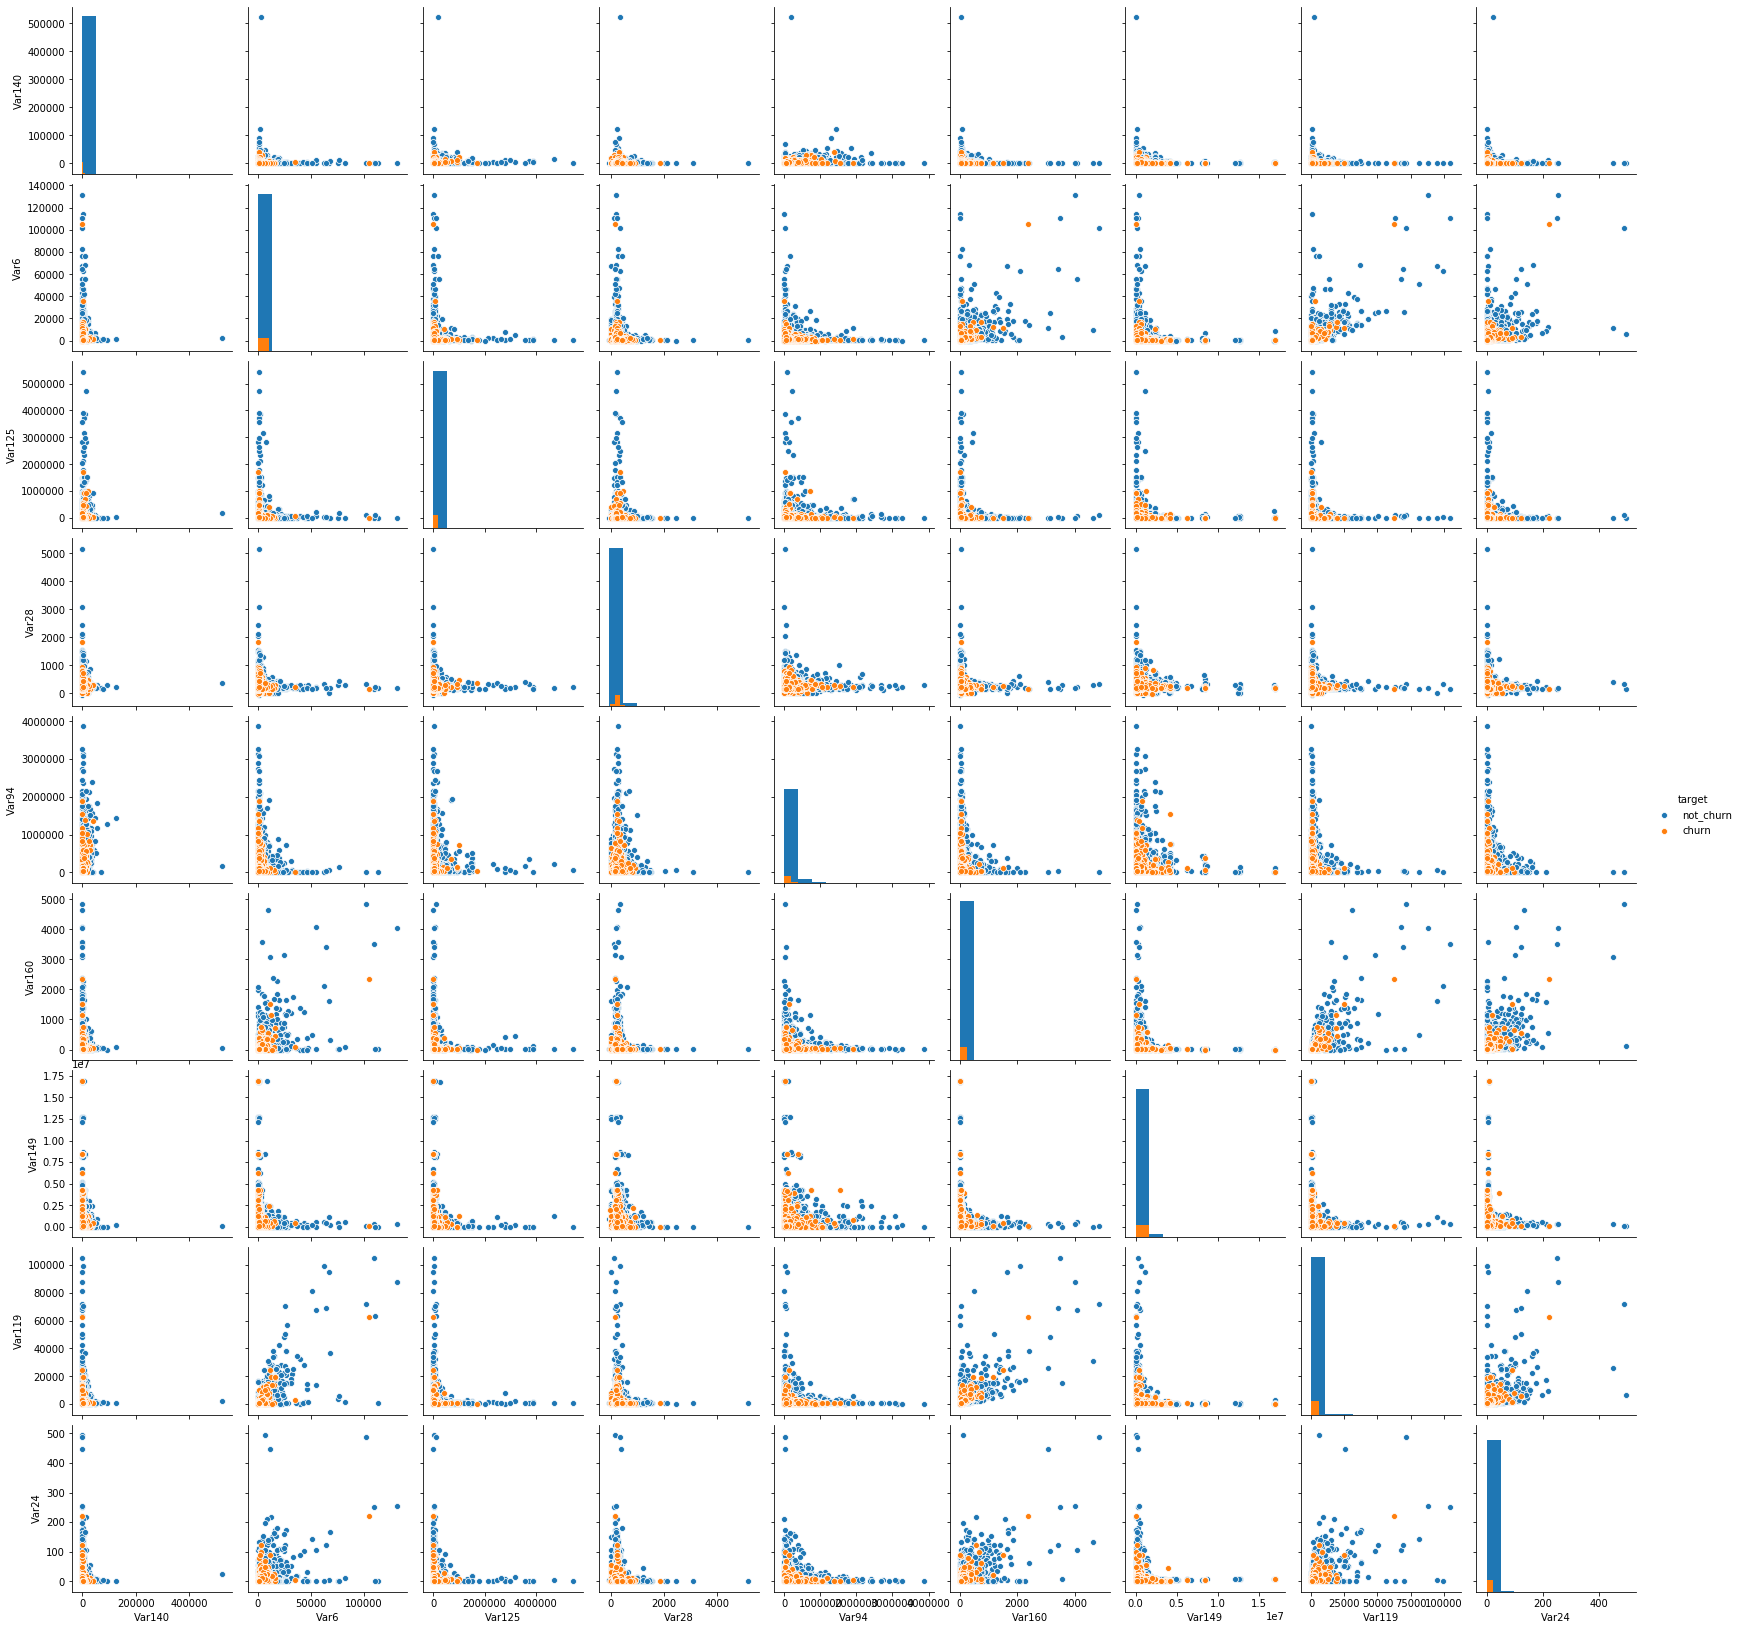

In [24]:
sns.pairplot(hue='target', data=matrix_corr.iloc[:, list(range(11, 20)) + [-1]], diag_kind='hist')

В признаках много коррелирующих. Линейные модели будут испытывать сложности, ансамблиевые методы будут работать с ними лучше. Некоторые признаки, обозначенные как числовые, более похожи на категориальные. Возможно, имеет смысл попробовать работать с ними как с категориальными. В данных много выбросов, линейные модели также будут испытывать сложности при работе с подобными данными.

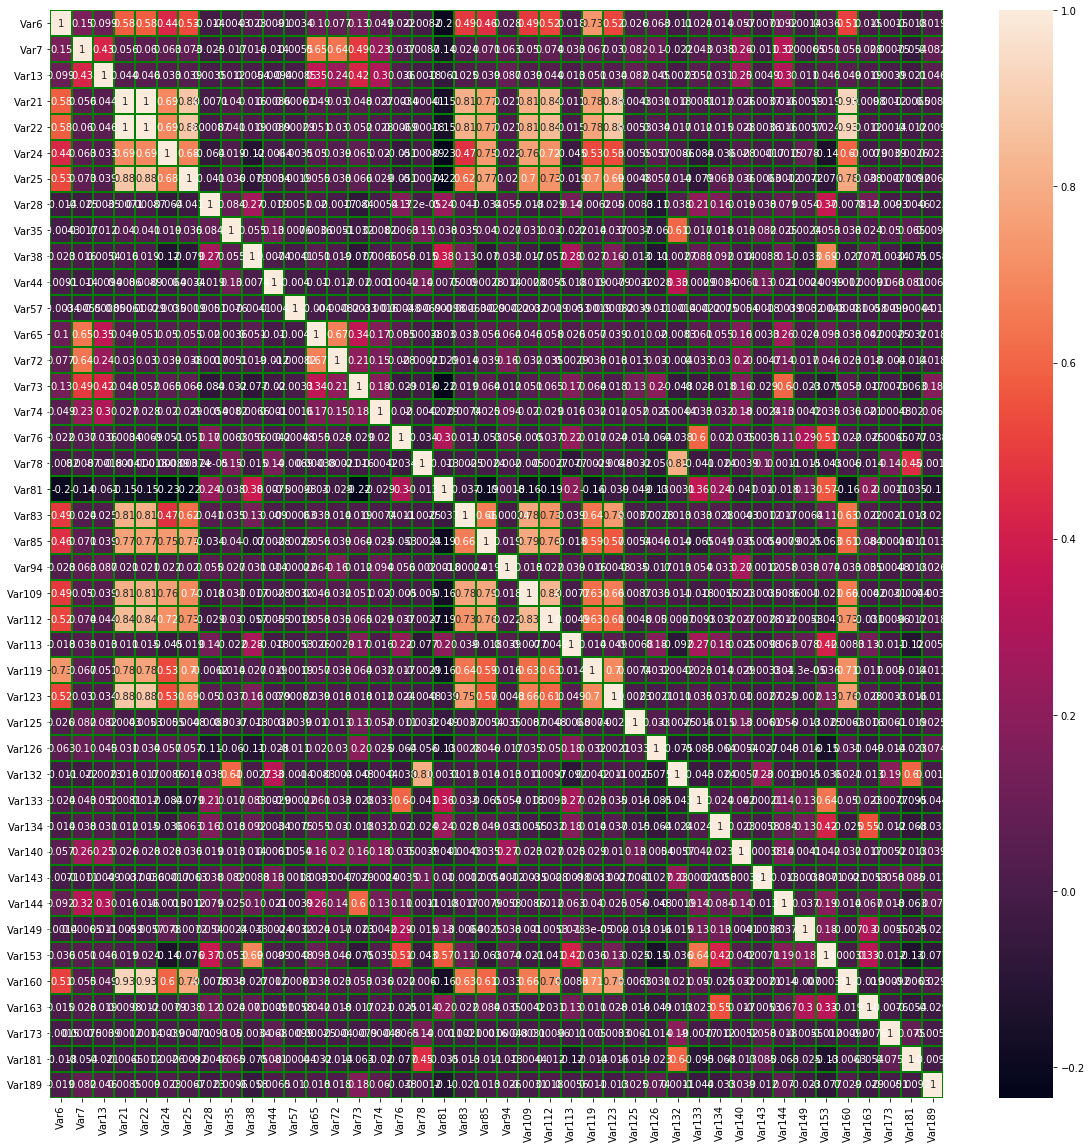

In [34]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(X[num_cols].corr(), linewidths=1, linecolor='g', annot=True)

Много числовых признаков, имеющих высокую корреляцию между друг другом. Ансамблиевые методы предпочтительнее линейных, поскольку не будут испытывать проблем с такими признаками

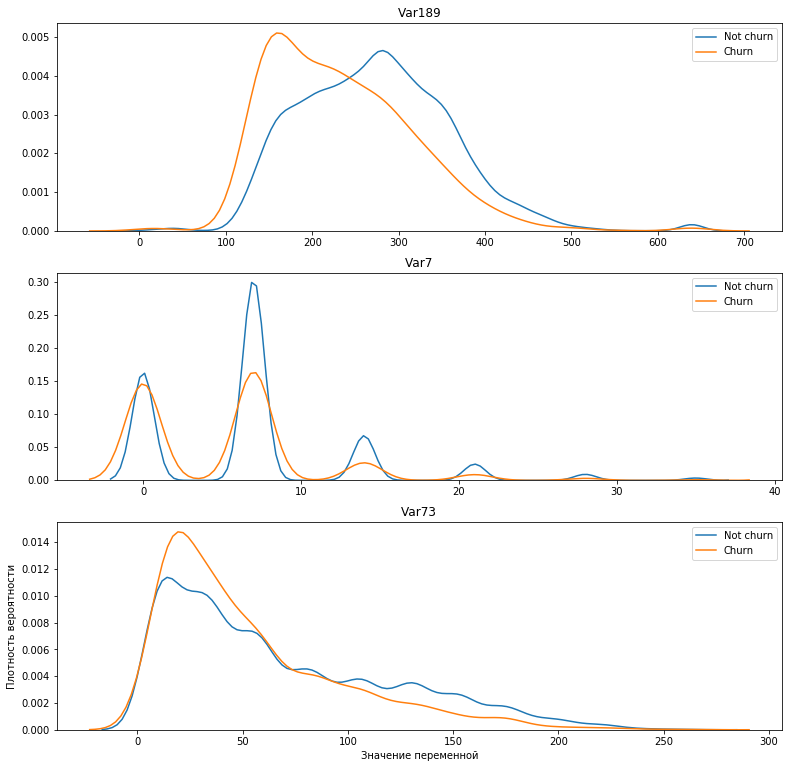

In [68]:

#построим графики распределения категорий
fig, axes = plt.subplots(3, 1, figsize=(13, 13))
for k, i in enumerate(['Var189', 'Var7', 'Var73']):

    sns.kdeplot(X_full[X_full['target']==-1][i], label='Not churn', ax=axes[k]).set_title(i)
    sns.kdeplot(X_full[X_full['target']==1][i], label='Churn' , ax=axes[k])
    plt.ylabel('Плотность вероятности')
    plt.xlabel('Значение переменной')


Плотности вероятностей для наиболее коррелированных признаков достаточно сильно накладываются друг на друга. Классификация будет достаточно затруднительна при таких данных. На последок посмотрим на распределения по признакам в табличном виде.

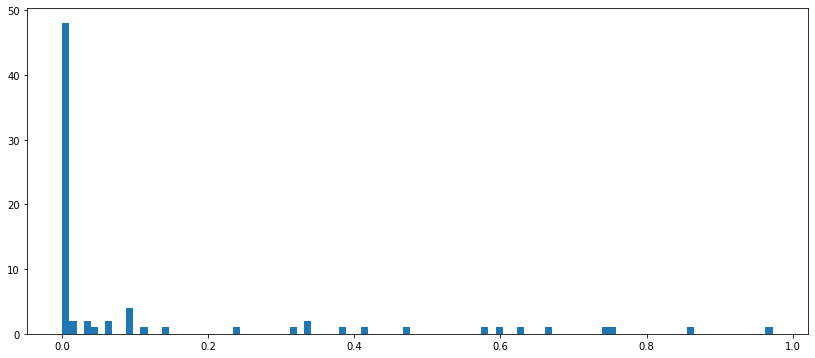

In [55]:
nunique = X.nunique(dropna=False)
plt.figure(figsize=(14,6))
_ = plt.hist(nunique.astype(float)/X.shape[0], bins=100)

In [62]:
#признаки с большим количеством уникальных значений
mask = (nunique.astype(float)/X.shape[0] > 0.8)
X.loc[:, mask]
#признаки явно числовые

,Var81,Var113
0,14599.92,-1209960.00
1,67529.09,417932.00
2,85266.00,-124655.20
3,74107.20,378473.60
4,171072.90,142602.40
...,...,...
39995,203000.70,175354.80
39996,24725.55,277286.80
39997,6269.55,20212.72
39998,22343.97,-66278.80


In [63]:
mask = (nunique.astype(float)/X.shape[0] < 0.8) & (nunique.astype(float)/X.shape[0] > 0.4)
X.loc[:25, mask]

,Var38,Var57,Var76,Var94,Var133,Var134,Var153,Var163
0,82752.0,2.907926,716008.0,NaN,326915.0,604276.0,2313888.0,599532.0
1,2706120.0,5.870327,1661128.0,32289.0,1934460.0,349568.0,6502680.0,364182.0
2,4698780.0,5.981628,3025152.0,53388.0,3148410.0,1086210.0,10569040.0,0.0
3,864384.0,5.108097,2642240.0,NaN,7066700.0,650390.0,9676200.0,253284.0
4,4364880.0,0.650716,1440.0,106455.0,3794460.0,642816.0,10535200.0,2851284.0
5,NaN,2.901517,NaN,NaN,NaN,NaN,NaN,NaN
6,6830160.0,4.745567,1874160.0,83541.0,2834535.0,712890.0,10627960.0,645630.0
7,2663046.0,6.256569,2534432.0,61131.0,6184700.0,633608.0,10524800.0,1900830.0
8,26628.0,3.445845,27816.0,54267.0,88650.0,13200.0,138484.0,12780.0
9,34644.0,3.630421,162040.0,82050.0,252485.0,15352.0,365860.0,19074.0


В некоторыз признаках значения достаточно большие, однако периодичски проскакивают нули. Возможно, это пропуски. Можно попробовать добавить соответствующий признак

In [64]:
mask = (nunique.astype(float)/X.shape[0] < 0.4) & (nunique.astype(float)/X.shape[0] > 0)
X.loc[:25, mask]

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var44,...,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
0,3052.0,NaN,NaN,480.0,600.0,20.0,480.0,200.00,0.0,0.0,...,FzaX,hLKtJ9p,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN
1,1813.0,7.0,636.0,212.0,265.0,2.0,128.0,166.56,0.0,0.0,...,FzaX,hN8KpA1,oslk,6hQ9lNX,LM8l689qOp,ELof,xb3V,RAYp,55YFVY9,mj86
2,1953.0,7.0,448.0,176.0,220.0,0.0,72.0,311.76,0.0,0.0,...,FzaX,4UxGlow,zCkv,catzS2D,LM8l689qOp,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86
3,1533.0,7.0,4.0,332.0,415.0,0.0,144.0,220.08,5.0,0.0,...,FzaX,ylCK5YS,oslk,e4lqvY0,LM8l689qOp,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN
4,686.0,7.0,0.0,160.0,200.0,2.0,48.0,278.00,0.0,0.0,...,FzaX,PYpzAu9,oslk,MAz3HNj,LM8l689qOp,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,FzaX,ClzupgV,d0EEeJi,6Uh67Lk,LM8l689qOp,NaN,453m,02N6s8f,F2FyR07IdsN7I,NaN
6,889.0,0.0,0.0,200.0,250.0,2.0,48.0,320.40,0.0,0.0,...,qxDb,0MQv48t,oslk,d0BOtEt,LM8l689qOp,NaN,3Cy4,RAYp,F2FyR07IdsN7I,NaN
7,161.0,0.0,0.0,120.0,150.0,4.0,32.0,286.96,0.0,0.0,...,FzaX,do06V3V,oslk,AmO2pc5,LM8l689qOp,NaN,5Acm,RAYp,F2FyR07IdsN7I,NaN
8,420.0,0.0,0.0,252.0,315.0,6.0,96.0,200.00,0.0,0.0,...,FzaX,gwj3_5u,oslk,APgu8Zv,LM8l689qOp,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN
9,1155.0,0.0,0.0,260.0,325.0,4.0,64.0,166.56,0.0,0.0,...,FzaX,CjQAfvB,oslk,JaZwBif,LM8l689qOp,NaN,uWr3,RAYp,F2FyR07IdsN7I,NaN


Интересный порядок наблюдается, когда у первых N признаков пропуски, а при переходе к остальным признакам пропуски отсутствуют. это может быть дополнительный признак. Например, признак, который присваивает 1 если пропуски имеются во всех колонках типа float кроме Var57/Var113, в них практически везде есть значения.

In [28]:
#дополнительно посмотрим на количество пропусков переменных, сильно коррелирующих с целевой
columns_to_check = df_corr['variable'].iloc[:10]
for col in columns_to_check:
    print(col, 'пропусков', X[col].isna().sum())
#у топовых по корреляции переменных много пропусков
#удалим из списка колонки без пропусков
columns_to_check.tolist().remove('Var7')
columns_to_check.tolist().remove('Var113')

Var189 пропусков 23215
Var7 пропусков 4440
Var73 пропусков 0
Var126 пропусков 11108
Var113 пропусков 0
Var144 пропусков 4435
Var13 пропусков 4440
Var65 пропусков 4440
Var72 пропусков 17937
Var81 пропусков 4435


### Категориальные признаки

Организаторами, которые предоставили данные, было указано, что категориальные признаки - Var190 - Var230. Посмотрим на их распределения

In [4]:
#Судя по всему в данных много редких категорий, это тоже нехорошо. Посмотрим на количество категорий внутри признаков
for column in X[cat_cols].columns:
    print(X[column].value_counts(dropna=False))

Много категориальных признаков, где встречаются редкие категории. Можно попробовать обработать и укрупнить данные категории в одну. Посмотрим на категориальные признаки,в  которых не больше 100 категорий

In [26]:
#тут будем хранить переменные
count_container = []
for column in X[cat_cols].columns:
    count_container.append([column, pd.value_counts(X[column]).shape[0]])
#отберем только те, где категорий меньше 100
categorical_100 = pd.DataFrame(count_container, columns=['Variable',
                                                         'Value']).sort_values(by='Value', ascending=False)
categorical_100 = categorical_100[categorical_100['Value'] <= 100]['Variable']
categorical_100.shape

(23,)

In [30]:
X_full = pd.concat((X, y), axis=1).rename(columns={0 : 'target'})

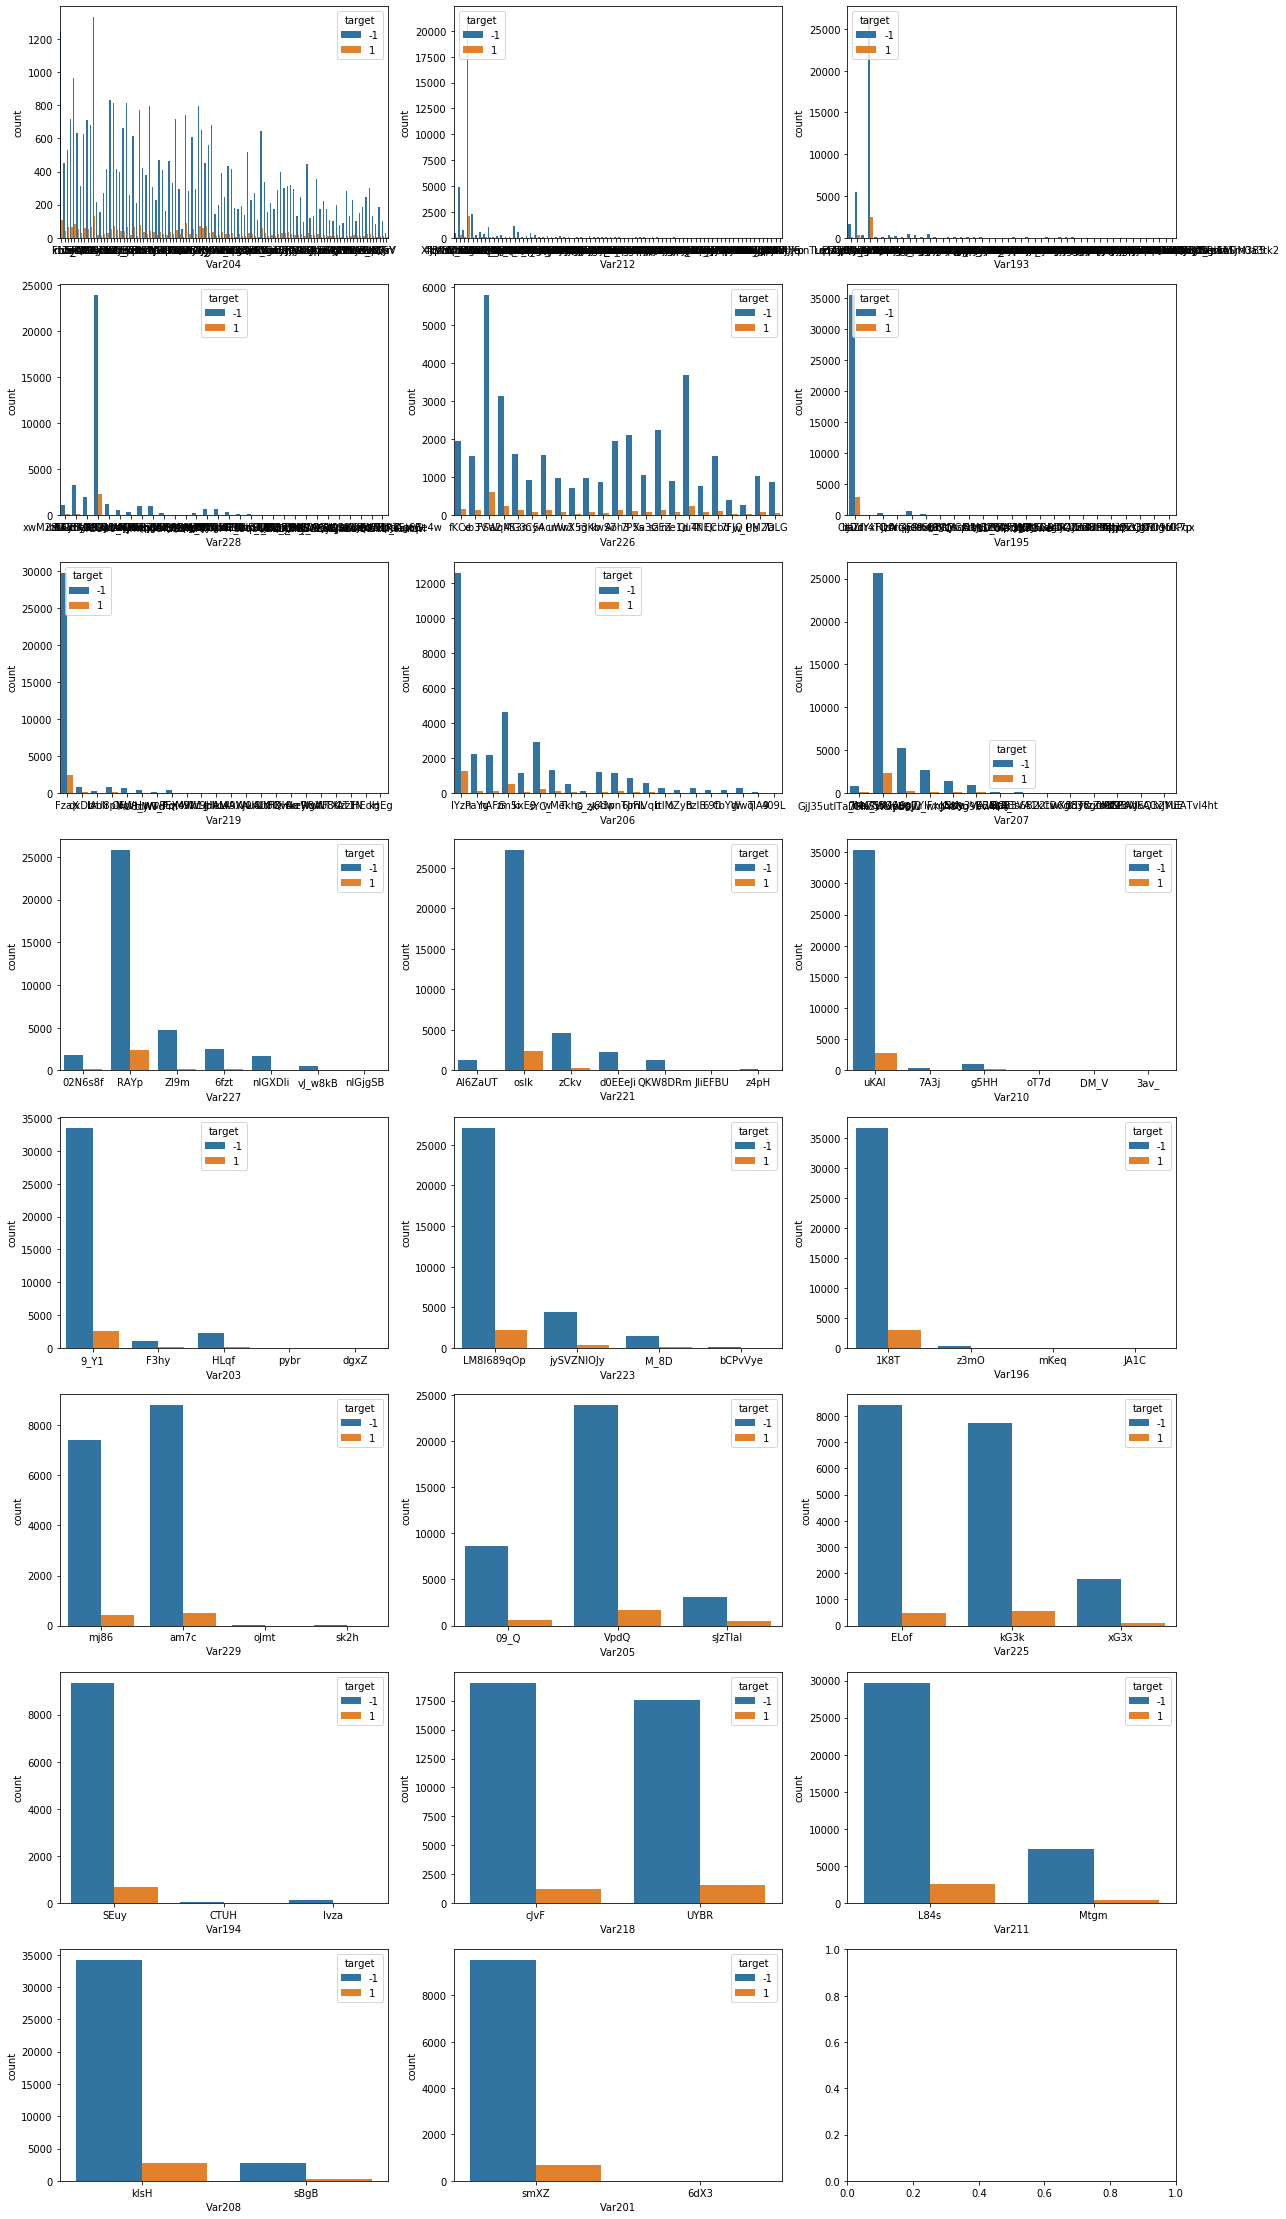

In [33]:
#построим графики распределения категорий
fig, axes = plt.subplots(8, 3, figsize=(20, 40))
for i in range(len(categorical_100)):
    sns.countplot(x=categorical_100.iloc[i], data=X_full,
                 ax=axes[i // 3, i % 3], hue=X_full['target'])

В данных признаках так же очень много редких категорий, нужно учесть при построении модели.
Так же многие признаки, отнесенные к числовым, не выглядят как числовые. Проанализируем их, поскольку маловероятно наличие в числовых признаках порядка двух десятков уникальных значений.

In [44]:
n_uniq_numeric = X[num_cols].nunique(dropna=False).sort_values(ascending=True)
n_uniq_numeric

Var173        5
Var143        5
Var7          7
Var181        8
Var44         9
Var72         9
Var144       11
Var35        13
Var78        14
Var65        14
Var132       19
Var126       52
Var24        83
Var189       96
Var73       131
Var85       137
Var83       178
Var109      191
Var112      208
Var25       247
Var123      264
Var74       350
Var160      365
Var21       670
Var22       670
Var119     1362
Var6       1368
Var13      2445
Var140     2453
Var28      3760
Var125     9449
Var149    15283
Var94     16657
Var163    18738
Var57     23022
Var76     24082
Var38     24998
Var134    26814
Var153    29786
Var133    30307
Var81     34546
Var113    38902
dtype: int64

In [48]:
X[['Var173', 'Var143', 'Var7', 'Var181', 'Var44', 'Var72', 'Var144', 'Var35', 'Var78', 'Var65', 'Var132']].head(20)

,Var173,Var143,Var7,Var181,Var44,Var72,Var144,Var35,Var78,Var65,Var132
0,0.0,0.0,NaN,0.0,0.0,NaN,9.0,0.0,0.0,NaN,0.0
1,0.0,0.0,7.0,0.0,0.0,3.0,18.0,0.0,0.0,27.0,0.0
2,0.0,0.0,7.0,0.0,0.0,3.0,27.0,0.0,0.0,18.0,0.0
3,0.0,0.0,7.0,0.0,0.0,NaN,0.0,5.0,0.0,9.0,8.0
4,0.0,0.0,7.0,0.0,0.0,3.0,9.0,0.0,0.0,9.0,0.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0,0.0,0.0,0.0,0.0,6.0,9.0,0.0,0.0,18.0,0.0
7,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,18.0,0.0
8,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,9.0,0.0
9,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,9.0,0.0


Данные признаки явно не выглядят как числовые, боже похожи на счетчики/категории. Кроме того, есть такие строки, как уже было видно, где почти всюду отсутвутют признаки

### Дополнительные признаки

На основе EDA добавим признаки.
1. 1 если все признаки численного типа (кроме Var53, Var113) равны NaN, 0 иначе
2. сумма NaN по всем признакам численного типа
3. для признаков типа str/obj сумма пропусков по строке
4. для топ 10 по корреляции с целевой меткой переменных добавим 1 если есть пропуск, иначе 0

In [62]:
cols = num_cols.tolist()
cols.remove('Var57')
cols.remove('Var113')
#признак 1
X['IsAllNaNs'] = np.where(X[cols].isna().sum(axis=1)==38, 1, 0)
X['SumByRowF'] = X[cols].isnull().sum(axis=1)
X['SubByRowS'] = X[cat_cols].isnull().sum(axis=1)

In [63]:
for col in columns_to_check:
    X[col+'_usnull'] = np.where(X[col].isna(), 1, 0)

### Baseline

Построим пару BaseLine, чтобы понять основные проблемы в данных. Целевая метрика - roc_auc. Используем несколько обычных классификаторов, так как будут использоваться метрические методы, необходимо задать конкеер преподготовки данных. В данных много категориальных признаков с большим количеством категорий, преобразования для линейных и ансамблиевых методов будут разные.

In [43]:
#категориальные признаки
cat_pipe_lin = Pipeline([('imp', SimpleImputer(strategy='constant', fill_value='-999')),
                         ('encoding', OneHotEncoder(handle_unknown='ignore'))])

num_pipe_lin = Pipeline([('imp', SimpleImputer(strategy='mean')),
                         ('scaler', StandardScaler())])
#собираем в цепочку преобразований
transformer_lin = [('cat', cat_pipe_lin, cat_cols), ('num', num_pipe_lin, num_cols)]
transformer = ColumnTransformer(transformers=transformer_lin)

In [44]:
baseline_pipeline_lin = Pipeline([('transofrm', transformer), ('estimator', LogisticRegression(random_state=17, max_iter=1000))])

In [45]:
#категориальные признаки
cat_pipe = Pipeline([('imp', SimpleImputer(strategy='constant', fill_value='-999')),
                    ('encoding', OrdinalEncoder())])

num_pipe = Pipeline([('imp', SimpleImputer(strategy='mean'))])
#собираем в цепочку преобразований
transformer = [('cat', cat_pipe, cat_cols),
              ('num', num_pipe, num_cols)]
transformer = ColumnTransformer(transformers=transformer)

In [46]:
baseline_pipeline_rf = Pipeline([('transofrm', transformer), ('estimator', RandomForestClassifier(random_state=17))])
baseline_pipeline_gb = Pipeline([('transofrm', transformer), ('estimator', GradientBoostingClassifier(random_state=17))])

In [47]:
print('ROC-AUC score for LogReg out-of-box is: ', cross_val_score(baseline_pipeline_lin, X, np.ravel(y),
                                                              scoring='roc_auc',
                                                              cv=StratifiedShuffleSplit(n_splits=5, random_state=17)).mean())

ROC-AUC score for LogReg out-of-box is:  0.6397675481056856


In [48]:
print('ROC-AUC score for RandomForest out-of-box is: ', cross_val_score(baseline_pipeline_rf, X, np.ravel(y), 
                                                                        scoring='roc_auc',
                                                                        cv=StratifiedShuffleSplit(n_splits=5, random_state=17)).mean())

ROC-AUC score for RandomForest out-of-box is:  0.6602630901489853


In [49]:
print('ROC-AUC score for GB out-of-box is: ', cross_val_score(baseline_pipeline_gb, X, np.ravel(y),
                                                              scoring='roc_auc',
                                                              cv=StratifiedShuffleSplit(n_splits=5, random_state=17)).mean())

ROC-AUC score for GB out-of-box is:  0.7157447996548211


Наилучший результат показал градиентный бустинг

### Выводы


* В данных много пропусков, нужно попробовать разные методы импутации
* Есть признаки, хорошо коррелирующие с целевой меткой
* Есть признаки, в которых очень много редких категорий, можно попробовать стратегию укрупнения редких категорий
* Есть признаки, в которых только 1 категория и NaN, нужно попробовать их удаление
* Много признаков, где практически все значения - пропуски. Надо подобрать границу выброса таких признаков
* Есть линейно-зависимые признаки, линейные модели без регуляризации могут испытывать трудности
* Лучший результат out-of-box показывает градиентный бустинг, для решения будем пользоваться именно им